# Linear Regression Starter Kit for Kaggle House Prices 

## Imports and inits

In [1]:
import h2o
h2o.init(max_mem_size='12G') # give h2o as much memory as possible
h2o.remove_all()
h2o.no_progress() # turn off h2o progress bars

import numpy as np
import pandas as pd

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpbvasq60h
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpbvasq60h/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpbvasq60h/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster version:,3.10.0.10
H2O cluster version age:,6 months and 23 days !!!
H2O cluster name:,H2O_from_python_phall_mwhlhs
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


## Import data

In [2]:
train = h2o.import_file('../data/train.csv')
test = h2o.import_file('../data/test.csv')

#### Determine data types

In [3]:
def get_type_lists(frame=train, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [4]:
original_nums, cats = get_type_lists()

Numeric = ['BsmtUnfSF', 'MasVnrArea', '1stFlrSF', 'LotFrontage', 'Fireplaces', 'GarageYrBlt', '2ndFlrSF', 'YearBuilt', 'HalfBath', 'MiscVal', 'BedroomAbvGr', 'MSSubClass', 'BsmtFinSF1', 'YearRemodAdd', 'LotArea', 'BsmtFullBath', 'GarageCars', 'GrLivArea', 'BsmtHalfBath', 'BsmtFinSF2', 'OverallCond', 'MoSold', 'WoodDeckSF', 'OpenPorchSF', 'KitchenAbvGr', 'ScreenPorch', 'EnclosedPorch', 'PoolArea', 'TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd', 'GarageArea', 'LowQualFinSF', 'OverallQual', '3SsnPorch', 'YrSold']

Categorical = ['Street', 'Condition2', 'RoofStyle', 'Functional', 'PavedDrive', 'Alley', 'Heating', 'BsmtFinType2', 'Exterior2nd', 'Condition1', 'Fence', 'ExterCond', 'BsmtFinType1', 'Exterior1st', 'LotConfig', 'SaleCondition', 'MiscFeature', 'FireplaceQu', 'BsmtCond', 'PoolQC', 'SaleType', 'BldgType', 'Electrical', 'ExterQual', 'LandContour', 'GarageFinish', 'GarageType', 'MSZoning', 'LotShape', 'GarageQual', 'BsmtQual', 'KitchenQual', 'GarageCond', 'LandSlope', 'RoofMatl', 'Utiliti

## Impute numeric missing

In [5]:
# median usually better than mean
# (_ signifies temporary throw-away variable, used to suppress output)
_ = train[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = test[['BsmtHalfBath', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtUnfSF', 'MasVnrArea', 
          'GarageYrBlt', 'LotFrontage', 'GarageCars', 'TotalBsmtSF', 'GarageArea']].impute(method='median')

## Encode categorical using shrunken averages
http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.ps

In [6]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):

    """ Applies simple target encoding to categorical variables.

    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames.

    """

    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series


    # create dictionary of level:encode val

    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)

    row_val_dict[np.nan] = overall_mean # handle missing values

    if test:
        print(row_val_dict)

    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])

    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    # handle values that are seen in tsdf but not row_val_dict
    for i, col_i in enumerate(tsdf[x]):
        try:
            row_val_dict[col_i]
        except:
            # a value that appeared in tsdf isn't in the row_val_dict so just
            # make it the overall_mean
            row_val_dict[col_i] = overall_mean
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])


    # convert back to H2O

    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]

    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]

    return (trdf, tsdf)


#### Execute encoding

In [7]:
for i, var in enumerate(cats):
    
    total = len(cats)
    tr_enc, ts_enc = target_encoder(train, test, var, 'SalePrice')

    print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    train = train.cbind(tr_enc)
    test = test.cbind(ts_enc)    
    
print('Done.')

Encoding: Street (1/43) ...
Encoding: Condition2 (2/43) ...
Encoding: RoofStyle (3/43) ...
Encoding: Functional (4/43) ...
Encoding: PavedDrive (5/43) ...
Encoding: Alley (6/43) ...
Encoding: Heating (7/43) ...
Encoding: BsmtFinType2 (8/43) ...
Encoding: Exterior2nd (9/43) ...
Encoding: Condition1 (10/43) ...
Encoding: Fence (11/43) ...
Encoding: ExterCond (12/43) ...
Encoding: BsmtFinType1 (13/43) ...
Encoding: Exterior1st (14/43) ...
Encoding: LotConfig (15/43) ...
Encoding: SaleCondition (16/43) ...
Encoding: MiscFeature (17/43) ...
Encoding: FireplaceQu (18/43) ...
Encoding: BsmtCond (19/43) ...
Encoding: PoolQC (20/43) ...
Encoding: SaleType (21/43) ...
Encoding: BldgType (22/43) ...
Encoding: Electrical (23/43) ...
Encoding: ExterQual (24/43) ...
Encoding: LandContour (25/43) ...
Encoding: GarageFinish (26/43) ...
Encoding: GarageType (27/43) ...
Encoding: MSZoning (28/43) ...
Encoding: LotShape (29/43) ...
Encoding: GarageQual (30/43) ...
Encoding: BsmtQual (31/43) ...
Encoding:

#### Redefine numerics and explore

In [8]:
encoded_nums, cats = get_type_lists(frame=train)

Numeric = ['BsmtUnfSF', 'MasVnrArea', 'Condition1_Tencode', '1stFlrSF', 'LotFrontage', 'Fireplaces', 'Foundation_Tencode', 'GarageYrBlt', '2ndFlrSF', 'BsmtFinSF2', 'GarageType_Tencode', 'HalfBath', 'Alley_Tencode', 'RoofMatl_Tencode', 'MiscVal', 'SaleCondition_Tencode', 'BedroomAbvGr', 'MSSubClass', 'BsmtFinSF1', 'YearRemodAdd', 'ExterQual_Tencode', 'LotShape_Tencode', 'BsmtFullBath', 'GarageCars', 'Exterior2nd_Tencode', 'PavedDrive_Tencode', 'BsmtExposure_Tencode', 'Electrical_Tencode', 'GrLivArea', 'BldgType_Tencode', 'Street_Tencode', 'MasVnrType_Tencode', 'PoolQC_Tencode', 'BsmtHalfBath', 'Neighborhood_Tencode', 'LotConfig_Tencode', 'ExterCond_Tencode', 'BsmtFinType1_Tencode', 'MoSold', 'OverallQual', 'OverallCond', 'FullBath', 'GarageCond_Tencode', 'OpenPorchSF', 'MiscFeature_Tencode', 'KitchenAbvGr', 'Condition2_Tencode', 'GarageQual_Tencode', 'GarageFinish_Tencode', 'ScreenPorch', 'EnclosedPorch', 'YearBuilt', 'BsmtFinType2_Tencode', 'TotalBsmtSF', 'Exterior1st_Tencode', 'Firepl

In [9]:
print('Imputed and encoded numeric training data:')
train[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
test[encoded_nums].describe() #79 numeric columns w/ no missing

Imputed and encoded numeric training data:
Rows:1460
Cols:79




,BsmtUnfSF,MasVnrArea,Condition1_Tencode,1stFlrSF,LotFrontage,Fireplaces,Foundation_Tencode,GarageYrBlt,2ndFlrSF,BsmtFinSF2,GarageType_Tencode,HalfBath,Alley_Tencode,RoofMatl_Tencode,MiscVal,SaleCondition_Tencode,BedroomAbvGr,MSSubClass,BsmtFinSF1,YearRemodAdd,ExterQual_Tencode,LotShape_Tencode,BsmtFullBath,GarageCars,Exterior2nd_Tencode,PavedDrive_Tencode,BsmtExposure_Tencode,Electrical_Tencode,GrLivArea,BldgType_Tencode,Street_Tencode,MasVnrType_Tencode,PoolQC_Tencode,BsmtHalfBath,Neighborhood_Tencode,LotConfig_Tencode,ExterCond_Tencode,BsmtFinType1_Tencode,MoSold,OverallQual,OverallCond,FullBath,GarageCond_Tencode,OpenPorchSF,MiscFeature_Tencode,KitchenAbvGr,Condition2_Tencode,GarageQual_Tencode,GarageFinish_Tencode,ScreenPorch,EnclosedPorch,YearBuilt,BsmtFinType2_Tencode,TotalBsmtSF,Exterior1st_Tencode,FireplaceQu_Tencode,Heating_Tencode,HouseStyle_Tencode,LandContour_Tencode,GarageArea,Fence_Tencode,LowQualFinSF,MSZoning_Tencode,WoodDeckSF,LotArea,LandSlope_Tencode,TotRmsAbvGrd,3SsnPorch,CentralAir_Tencode,YrSold,RoofStyle_Tencode,BsmtCond_Tencode,KitchenQual_Tencode,HeatingQC_Tencode,PoolArea,Functional_Tencode,SaleType_Tencode,Utilities_Tencode,BsmtQual_Tencode
type,int,real,real,int,real,int,real,real,int,int,real,int,real,real,int,real,int,int,int,int,real,real,int,int,real,real,real,real,int,real,real,real,real,int,real,real,real,real,int,int,int,int,real,int,real,int,real,real,real,int,int,int,real,int,real,real,real,real,real,int,real,int,real,int,int,real,int,int,real,int,real,real,real,real,int,real,real,real,real
mins,0.0,0.0,141966.09605022828,334.0,21.0,0.0,118398.96063356163,1900.0,0.0,0.0,120605.97382800607,0.0,131024.39738356163,143588.17938356166,0.0,115644.42938356163,0.0,20.0,0.0,1950.0,101925.61152641877,164754.81837837838,0.0,0.0,116388.17938356163,124921.43327245054,165652.29590766,84088.17938356164,334.0,136305.59873840035,137800.10438356164,151508.53605022831,180921.19589041095,0.0,110928.17938356163,176938.0475285171,92163.17938356164,151994.04028581732,1.0,1.0,1.0,0.0,119363.17938356163,0.0,107038.17938356163,0.0,109375.67938356163,112279.84605022831,142156.42314049587,0.0,0.0,1872.0,155574.02938356163,0.0,87488.17938356164,137437.70688356162,88763.17938356164,120765.67938356163,148776.6468438791,0.0,141281.58847447074,0.0,90486.97938356163,0.0,1300.0,179956.7995658466,2.0,0.0,116612.64201514059,2006.0,153710.9066562889,81538.17938356164,116868.60374253601,101088.17938356164,0.0,100068.17938356164,129010.67938356163,144013.17938356166,125476.40366927591
mean,567.2404109589041,103.68526170798899,181383.89587446052,1162.626712328767,70.04995836802664,0.613013698630137,181839.7781230531,1978.5061638868744,346.99246575342465,46.54931506849315,184682.71746706698,0.38287671232876713,178903.9882177238,180756.55353696752,43.489041095890414,180217.29174554325,2.8664383561643834,56.897260273972606,443.6397260273973,1984.8657534246574,180058.82286939386,180636.96109490524,0.42534246575342466,1.7671232876712328,181031.77015866013,181680.14683289544,181624.85937051979,181738.1697731751,1515.463698630137,181528.18075483205,180952.46823719272,179556.69860888534,181358.14341400826,0.057534246575342465,180373.08053504408,180509.66312370988,181331.30861662602,183992.5769034997,6.321917808219178,6.0993150684931505,5.575342465753424,1.5650684931506849,185529.6042633233,46.66027397260274,180000.13846481516,1.0465753424657533,180958.04482243385,185465.54685972977,185226.61840213925,15.060958904109588,21.954109589041096,1971.267808219178,182969.4818640458,1057.4294520547944,180880.5669704916,199396.0979636423,181082.57937689996,181286.7320662882,180821.86755352785,472.9801369863014,175820.09948517545,5.844520547945206,180890.65145472885,94.2445205479452,10516.828082191782,180784.26482323135,6.517808219178082,3.4095890410958902,181659.6301311222,2007.8157534246575,180930.1805271627,182907.7643074686,179706.3537221336,181217.80597203973,2.758904109589041,181271.62194407952,179942.3916239914,180925.6569721805,181246.747384

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:1459
Cols:79




,BsmtUnfSF,MasVnrArea,Condition1_Tencode,1stFlrSF,LotFrontage,Fireplaces,Foundation_Tencode,GarageYrBlt,2ndFlrSF,BsmtFinSF2,GarageType_Tencode,HalfBath,Alley_Tencode,RoofMatl_Tencode,MiscVal,SaleCondition_Tencode,BedroomAbvGr,MSSubClass,BsmtFinSF1,YearRemodAdd,ExterQual_Tencode,LotShape_Tencode,BsmtFullBath,GarageCars,Exterior2nd_Tencode,PavedDrive_Tencode,BsmtExposure_Tencode,Electrical_Tencode,GrLivArea,BldgType_Tencode,Street_Tencode,MasVnrType_Tencode,PoolQC_Tencode,BsmtHalfBath,Neighborhood_Tencode,LotConfig_Tencode,ExterCond_Tencode,BsmtFinType1_Tencode,MoSold,OverallQual,OverallCond,FullBath,GarageCond_Tencode,OpenPorchSF,MiscFeature_Tencode,KitchenAbvGr,Condition2_Tencode,GarageQual_Tencode,GarageFinish_Tencode,ScreenPorch,EnclosedPorch,YearBuilt,BsmtFinType2_Tencode,TotalBsmtSF,Exterior1st_Tencode,FireplaceQu_Tencode,Heating_Tencode,HouseStyle_Tencode,LandContour_Tencode,GarageArea,Fence_Tencode,LowQualFinSF,MSZoning_Tencode,WoodDeckSF,LotArea,LandSlope_Tencode,TotRmsAbvGrd,3SsnPorch,CentralAir_Tencode,YrSold,RoofStyle_Tencode,BsmtCond_Tencode,KitchenQual_Tencode,HeatingQC_Tencode,PoolArea,Functional_Tencode,SaleType_Tencode,Utilities_Tencode,BsmtQual_Tencode
type,real,real,real,int,real,int,real,real,int,real,real,int,real,real,int,real,int,int,real,int,real,real,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,int,int,int,int,real,int,real,int,real,real,real,int,int,int,real,real,real,real,real,real,real,real,real,int,real,int,int,real,int,int,real,int,real,real,real,real,int,real,real,real,real
mins,0.0,0.0,141966.09605022828,407.0,21.0,0.0,118398.96063356163,1895.0,0.0,0.0,120605.97382800607,0.0,131024.39738356163,179803.6792189679,0.0,115644.42938356163,0.0,20.0,0.0,1950.0,101925.61152641877,164754.81837837838,0.0,0.0,116388.17938356163,124921.43327245054,165652.29590766,109871.51271689495,407.0,136305.59873840035,137800.10438356164,151508.53605022831,180921.19589041095,0.0,110928.17938356163,176938.0475285171,92163.17938356164,151994.04028581732,1.0,1.0,1.0,0.0,119363.17938356163,0.0,107038.17938356163,0.0,117663.17938356163,112279.84605022831,142156.42314049587,0.0,0.0,1879.0,155574.02938356163,0.0,87488.17938356164,137437.70688356162,91118.89366927592,120765.67938356163,148776.6468438791,0.0,141281.58847447074,0.0,90486.97938356163,0.0,1470.0,179956.7995658466,3.0,0.0,116612.64201514059,2006.0,153710.9066562889,81538.17938356164,116868.60374253601,101088.17938356164,0.0,100068.17938356164,129010.67938356163,180921.19589041095,125476.40366927591
mean,554.2949245541838,100.70914127423823,181389.31663321095,1156.534612748458,68.58035714285714,0.5812200137080192,182394.1607868111,1977.7212165097756,325.9677861549006,52.61934156378601,184656.7295734541,0.3776559287183002,178248.7290662322,180110.94715035174,58.16792323509253,179879.1401656116,2.8540095956134337,57.37834132967786,439.2037037037037,1983.6627827278958,180460.36175619633,180249.28067462493,0.4344543582704186,1.7661179698216736,180766.37959959693,180094.9269028509,181657.00791990335,181890.53298830043,1486.0459218642907,181077.96729000125,180952.34618765383,178895.07396658702,181293.60332733998,0.06520247083047358,178691.2305139906,180234.81382594892,180735.6325431525,184645.88361245434,6.104180945853324,6.078821110349555,5.5538039753255655,1.570938999314599,185422.7774534009,48.3139136394791,180005.30438727606,1.0424948594928032,181166.03732137335,184312.7546957362,184827.78985491671,17.064427690198766,24.24331734064427,1971.357779300891,183200.1159337163,1046.1179698216736,180163.89739622173,197633.5311456587,181709.8782401401,180645.5075029316,181450.84022501088,472.7688614540466,175663.07479793802,3.5435229609321452,179772.8336670903,93.17477724468814,9819.161069225496,180592.19026393845,6.385195339273475,1.794379712131597,181370.41046901883,2007.7697052775875,180180.92858796637,182176.8367729062,179420.17532378223,181724.34342026233,1.7443454420836186,181323.9571258677,179613.55995767802,180950.9160234005,181935.063499

In [10]:
# Check Neighborhood_Tencode

print(test[0:5, ['Neighborhood', 'Neighborhood_Tencode']])
_, _ = target_encoder(train, test, 'Neighborhood', 'SalePrice', test=True)
del _

# NAmes   145847
# NAmes   145847
# Gilbert 191064
# Gilbert 191064
# StoneBr 291062

Neighborhood,Neighborhood_Tencode
NAmes,145847
NAmes,145847
Gilbert,191065
Gilbert,191065
StoneBr,291062



{'Veenker': 230094.99756537983, nan: 180921.19589041095, 'NridgHt': 295968.20925369154, 'Blueste': 144013.17938356166, 'NoRidge': 312139.1988957568, 'Blmngtn': 192778.42938356166, 'Sawyer': 143412.3442484265, 'NWAmes': 187830.7376027397, 'Gilbert': 191064.5097633085, 'StoneBr': 291062.3293835616, 'Edwards': 136124.92438356165, 'SawyerW': 185710.60650220572, 'IDOTRR': 112243.39559977785, 'Timber': 233048.5096467195, 'Crawfor': 206169.19605022832, 'CollgCr': 197965.77333333335, 'BrDale': 115957.86688356164, 'Somerst': 218711.04101146862, 'NAmes': 145847.08, 'OldTown': 136129.68513577402, 'NPkVill': 148428.4571613394, 'Mitchel': 159967.78346519428, 'BrkSide': 133247.12334907887, 'MeadowV': 110928.17938356164, 'SWISU': 148340.8353835616, 'ClearCr': 207818.79366927594}


## Create combination features

In [11]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame


In [12]:
train, test = feature_combiner(train, test, encoded_nums)

Combining: BsmtUnfSF (1/79) ...
Combining: MasVnrArea (2/79) ...
Combining: Condition1_Tencode (3/79) ...
Combining: 1stFlrSF (4/79) ...
Combining: LotFrontage (5/79) ...
Combining: Fireplaces (6/79) ...
Combining: Foundation_Tencode (7/79) ...
Combining: GarageYrBlt (8/79) ...
Combining: 2ndFlrSF (9/79) ...
Combining: BsmtFinSF2 (10/79) ...
Combining: GarageType_Tencode (11/79) ...
Combining: HalfBath (12/79) ...
Combining: Alley_Tencode (13/79) ...
Combining: RoofMatl_Tencode (14/79) ...
Combining: MiscVal (15/79) ...
Combining: SaleCondition_Tencode (16/79) ...
Combining: BedroomAbvGr (17/79) ...
Combining: MSSubClass (18/79) ...
Combining: BsmtFinSF1 (19/79) ...
Combining: YearRemodAdd (20/79) ...
Combining: ExterQual_Tencode (21/79) ...
Combining: LotShape_Tencode (22/79) ...
Combining: BsmtFullBath (23/79) ...
Combining: GarageCars (24/79) ...
Combining: Exterior2nd_Tencode (25/79) ...
Combining: PavedDrive_Tencode (26/79) ...
Combining: BsmtExposure_Tencode (27/79) ...
Combining

#### Redefine numerics and explore

In [13]:
encoded_combined_nums, cats = get_type_lists(frame=train)

Numeric = ['Neighborhood_Tencode|LandSlope_Tencode', '1stFlrSF|BsmtFinType2_Tencode', 'BsmtUnfSF|BsmtFinType1_Tencode', 'Foundation_Tencode|BsmtFinType1_Tencode', 'LotArea|CentralAir_Tencode', 'YearRemodAdd|RoofStyle_Tencode', 'Alley_Tencode|ScreenPorch', 'ExterQual_Tencode|RoofStyle_Tencode', 'MasVnrArea|LotArea', 'Alley_Tencode|Fence_Tencode', 'BsmtUnfSF|BsmtQual_Tencode', 'GarageQual_Tencode|SaleType_Tencode', 'ExterQual_Tencode|Neighborhood_Tencode', 'MasVnrArea|Alley_Tencode', 'Electrical_Tencode|HouseStyle_Tencode', 'LotShape_Tencode|GarageFinish_Tencode', 'MasVnrArea|LotConfig_Tencode', 'TotRmsAbvGrd|3SsnPorch', 'GarageFinish_Tencode|YearBuilt', 'BsmtUnfSF|Neighborhood_Tencode', 'RoofMatl_Tencode|GarageArea', 'YearRemodAdd|SaleType_Tencode', 'Heating_Tencode|Functional_Tencode', 'Neighborhood_Tencode|FullBath', 'BsmtUnfSF|HalfBath', 'SaleCondition_Tencode|MSZoning_Tencode', 'KitchenAbvGr|BsmtQual_Tencode', 'EnclosedPorch|KitchenQual_Tencode', 'MiscVal|OverallQual', 'RoofMatl_Ten

In [14]:
# check number of created variables is correct
# 1 id column, 1 target column, 79 original + encoded numeric columns, 43 original categorical variables
# sum(range(1, 79)) combined variables
print(train.shape == (1460, sum(range(1, 79), (79 + 43 + 1 + 1))))
print(test.shape == (1459, sum(range(1, 79), (79 + 43 + 1))))

True
True


In [15]:
# check multiplication for a random column
ridx = np.random.choice(sum(range(1, 79)))
combined_only = [name for name in encoded_combined_nums if name not in encoded_nums]
combined_check_vars = combined_only[ridx].split('|')
combined_check_vars.append(combined_only[ridx])

print(train[736, combined_check_vars])
print(test[637, combined_check_vars])

print(train[736, combined_check_vars[0]]*train[736, combined_check_vars[1]])
print(test[637, combined_check_vars[0]]*test[637, combined_check_vars[1]])

MiscVal,Neighborhood_Tencode,MiscVal|Neighborhood_Tencode
0,145847,0


MiscVal,Neighborhood_Tencode,MiscVal|Neighborhood_Tencode
0,136130,0



0.0
0.0


## Train constituent models (for inspection purposes)

In [16]:
h2o.show_progress()                                          # turn on progress bars
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # import GLM models
from h2o.grid.grid_search import H2OGridSearch               # grid search

SalePrice
12.2477
12.109
12.3172


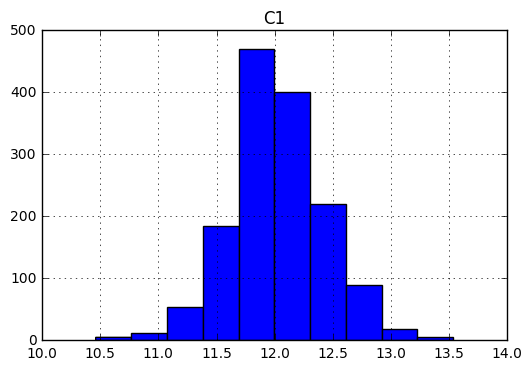

In [17]:
# Check log transform - looks good
%matplotlib inline
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
print(train[0:3, 'SalePrice'])

#### Split training data

In [18]:
base_train, base_valid, stack_train, stack_valid = train.split_frame([0.3, 0.2, 0.3], seed=12345)
print(base_train.shape)
print(base_valid.shape)
print(stack_train.shape)
print(stack_valid.shape)

(441, 3205)
(297, 3205)
(425, 3205)
(297, 3205)


#### Define model with grid search function

In [19]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {"alpha":alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best


## Train base level models

#### First model on original numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.25]  Grid_GLM_py_191_sid_a950_model_python_1496256600873_1_model_1   
1     [0.5]  Grid_GLM_py_191_sid_a950_model_python_1496256600873_1_model_2   
2    [0.99]  Grid_GLM_py_191_sid_a950_model_python_1496256600873_1_model_3   
3    [0.01]  Grid_GLM_py_191_sid_a950_model_python_1496256600873_1_model_0   

    residual_deviance  
0  6.1547872644675135  
1   6.176742787271307  
2    6.18777456413037  
3   6.222185404213095  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_191_sid_a950_model_python_1496256600873_1_model_1
GLM Model: summary



,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.25, lambda = 0.02277 )","nlambda = 100, lambda.max = 1.3649, lambda.min = 0.02277, lambda.1se = -1.0",36,24,0,py_191_sid_a950




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.030433677244580275
RMSE: 0.17445250713182736
MAE: 0.11944477286438474
RMSLE: 0.013420792192346001
R^2: 0.8278683153607944
Mean Residual Deviance: 0.030433677244580275
Null degrees of freedom: 440
Residual degrees of freedom: 416
Null deviance: 77.97083780937984
Residual deviance: 13.421251664859902
AIC: -236.55883023211004

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.02072318944265156
RMSE: 0.14395551202594348
MAE: 0.11068256137484296
RMSLE: 0.011125353076463345
R^2: 0.8607616808886678
Mean Residual Deviance: 0.02072318944265156
Null degrees of freedom: 296
Residual degrees of freedom: 272
Null deviance: 44.26529427591359
Residual deviance: 6.1547872644675135
AIC: -256.4715882901204
Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-05-31 11:50:45,0.000 sec,0,.13E1,2,0.1715065,0.1442587
,2017-05-31 11:50:45,0.001 sec,0,.12E1,2,0.1663340,0.1395944
,2017-05-31 11:50:45,0.002 sec,0,.12E1,2,0.1612922,0.1350533
,2017-05-31 11:50:45,0.003 sec,0,.11E1,2,0.1563858,0.1306395
,2017-05-31 11:50:45,0.005 sec,0,.11E1,2,0.1516189,0.1263565
---,---,---,---,---,---,---,---
,2017-05-31 11:50:45,0.149 sec,0,.16E-1,26,0.0300759,0.0207583
,2017-05-31 11:50:45,0.150 sec,0,.16E-1,26,0.0300370,0.0207626
,2017-05-31 11:50:45,0.152 sec,0,.15E-1,26,0.0300004,0.0207676
,2017-05-31 11:50:45,0.154 sec,0,.14E-1,26,0.0299672,0.0207743



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.109,12.2194
11.7745,12.1191
11.964,11.8372
12.6925,12.6562
11.9447,11.9856
12.1002,12.2708
12.6411,12.6413
11.8776,11.8451
11.7772,11.7651
12.428,12.3933


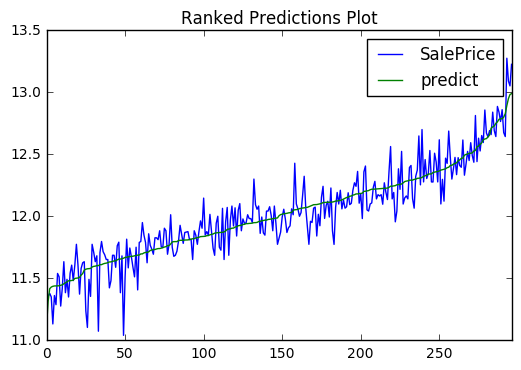

In [20]:
glm0 = glm_grid(original_nums, 'SalePrice', base_train, base_valid)

#### Second model on encoded numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.25]  Grid_GLM_py_191_sid_a950_model_python_1496256600873_2_model_1   
1     [0.5]  Grid_GLM_py_191_sid_a950_model_python_1496256600873_2_model_2   
2    [0.99]  Grid_GLM_py_191_sid_a950_model_python_1496256600873_2_model_3   
3    [0.01]  Grid_GLM_py_191_sid_a950_model_python_1496256600873_2_model_0   

   residual_deviance  
0  4.777745732439989  
1  4.789641170271538  
2  4.796646562983314  
3  4.837332740416697  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_191_sid_a950_model_python_1496256600873_2_model_1
GLM Model: summary



,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.25, lambda = 0.02075 )","nlambda = 100, lambda.max = 1.3649, lambda.min = 0.02075, lambda.1se = -1.0",79,50,0,py_191_sid_a950




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.019835337574875603
RMSE: 0.1408379834237753
MAE: 0.10071869102187328
RMSLE: 0.01088838983943605
R^2: 0.8878121087796349
Mean Residual Deviance: 0.019835337574875603
Null degrees of freedom: 440
Residual degrees of freedom: 390
Null deviance: 77.97083780937984
Residual deviance: 8.74738387052014
AIC: -373.344194563397

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.01608668596781141
RMSE: 0.12683329991690437
MAE: 0.0947201238322829
RMSLE: 0.009830179948659585
R^2: 0.8919141708167814
Mean Residual Deviance: 0.01608668596781141
Null degrees of freedom: 296
Residual degrees of freedom: 246
Null deviance: 44.26529427591359
Residual deviance: 4.777745732439989
AIC: -279.6902136430015
Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-05-31 11:50:47,0.000 sec,0,.13E1,2,0.1715065,0.1442587
,2017-05-31 11:50:47,0.001 sec,0,.12E1,2,0.1663340,0.1395944
,2017-05-31 11:50:47,0.002 sec,0,.12E1,3,0.1602977,0.1341616
,2017-05-31 11:50:47,0.004 sec,0,.11E1,3,0.1536219,0.1281660
,2017-05-31 11:50:47,0.005 sec,0,.11E1,3,0.1472498,0.1224546
---,---,---,---,---,---,---,---
,2017-05-31 11:50:47,0.157 sec,0,.16E-1,58,0.0191630,0.0162259
,2017-05-31 11:50:47,0.159 sec,0,.16E-1,59,0.0190530,0.0162671
,2017-05-31 11:50:47,0.161 sec,0,.15E-1,60,0.0189511,0.0163173
,2017-05-31 11:50:47,0.163 sec,0,.14E-1,60,0.0188551,0.0163721



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.109,12.2136
11.7745,11.8749
11.964,11.8281
12.6925,12.7863
11.9447,11.9575
12.1002,12.2231
12.6411,12.7155
11.8776,11.9755
11.7772,11.909
12.428,12.3594


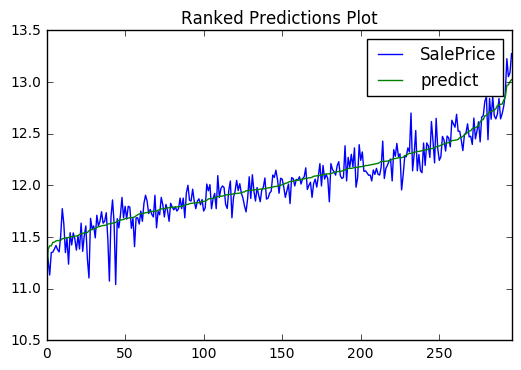

In [21]:
glm1 = glm_grid(encoded_nums, 'SalePrice', base_train, base_valid)

#### Third model on encoded numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.01]  Grid_GLM_py_191_sid_a950_model_python_1496256600873_3_model_0   
1     [0.5]  Grid_GLM_py_191_sid_a950_model_python_1496256600873_3_model_2   
2    [0.25]  Grid_GLM_py_191_sid_a950_model_python_1496256600873_3_model_1   
3    [0.99]  Grid_GLM_py_191_sid_a950_model_python_1496256600873_3_model_3   

    residual_deviance  
0   4.092867472621235  
1  4.1480419562737145  
2   4.150293040101234  
3  4.1591441635257125  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_191_sid_a950_model_python_1496256600873_3_model_0
GLM Model: summary



,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.01, lambda = 0.4027 )","nlambda = 100, lambda.max = 35.024, lambda.min = 0.4027, lambda.1se = -1.0",3151,666,0,py_191_sid_a950




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.01260667194700594
RMSE: 0.11227943688407926
MAE: 0.08038688681799125
RMSLE: 0.008764005859314044
R^2: 0.9286971580038561
Mean Residual Deviance: 0.01260667194700594
Null degrees of freedom: 440
Residual degrees of freedom: -226
Null deviance: 77.97083780937984
Residual deviance: 5.55954232862962
AIC: 658.7774595514335

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.013780698561014259
RMSE: 0.11739122011894355
MAE: 0.08286467719096442
RMSLE: 0.009137294841829747
R^2: 0.9074080122113641
Mean Residual Deviance: 0.013780698561014259
Null degrees of freedom: 296
Residual degrees of freedom: -370
Null deviance: 44.26529427591359
Residual deviance: 4.092867472621235
AIC: 906.3570514314706
Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-05-31 11:50:48,0.000 sec,0,.33E2,29,0.1743073,0.1468125
,2017-05-31 11:50:48,0.024 sec,0,.32E2,44,0.1688149,0.1419276
,2017-05-31 11:50:48,0.054 sec,0,.3E2,66,0.1619502,0.1358410
,2017-05-31 11:50:48,0.086 sec,0,.29E2,94,0.1542944,0.1290452
,2017-05-31 11:50:48,0.120 sec,0,.28E2,113,0.1464196,0.1220703
---,---,---,---,---,---,---,---
,2017-05-31 11:51:01,12.721 sec,0,.42E0,663,0.0127854,0.0137814
,2017-05-31 11:51:01,12.958 sec,0,.4E0,667,0.0126067,0.0137807
,2017-05-31 11:51:01,13.329 sec,0,.38E0,670,0.0124230,0.0137885
,2017-05-31 11:51:02,13.582 sec,0,.37E0,671,0.0122412,0.0137888



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
12.109,12.2077
11.7745,11.8448
11.964,11.7425
12.6925,12.7838
11.9447,11.9248
12.1002,12.1822
12.6411,12.6833
11.8776,11.9058
11.7772,11.8154
12.428,12.3908


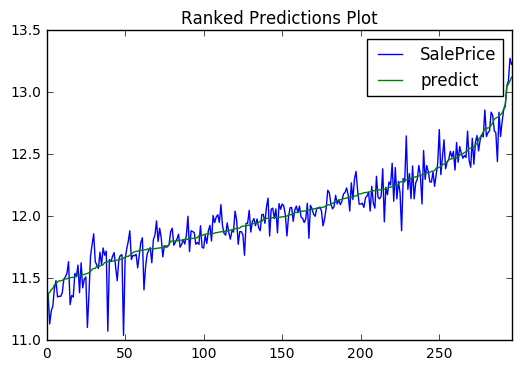

In [22]:
glm2 = glm_grid(encoded_combined_nums, 'SalePrice', base_train, base_valid)

## Train combiner model on second level data

#### Add prediction features to second level data and test data

In [23]:
stack_train = stack_train.cbind(glm0.predict(stack_train))
stack_valid = stack_valid.cbind(glm0.predict(stack_valid))
stack_train = stack_train.cbind(glm1.predict(stack_train))
stack_valid = stack_valid.cbind(glm1.predict(stack_valid))
stack_train = stack_train.cbind(glm2.predict(stack_train))
stack_valid = stack_valid.cbind(glm2.predict(stack_valid))

test = test.cbind(glm0.predict(test))
test = test.cbind(glm1.predict(test))
test = test.cbind(glm2.predict(test))

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


#### Train stack model

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.25]  Grid_GLM_py_213_sid_a950_model_python_1496256600873_4_model_1   
1     [0.5]  Grid_GLM_py_213_sid_a950_model_python_1496256600873_4_model_2   
2    [0.01]  Grid_GLM_py_213_sid_a950_model_python_1496256600873_4_model_0   
3    [0.99]  Grid_GLM_py_213_sid_a950_model_python_1496256600873_4_model_3   

    residual_deviance  
0  3.6959435264738594  
1  3.7147179860559043  
2  3.7238860861432173  
3   3.744716811694911  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_213_sid_a950_model_python_1496256600873_4_model_1
GLM Model: summary



,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.25, lambda = 0.01587 )","nlambda = 100, lambda.max = 1.4456, lambda.min = 0.01587, lambda.1se = -1.0",3147,112,0,py_213_sid_a950




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.008902565202056876
RMSE: 0.09435340588477385
MAE: 0.06814956635363129
RMSLE: 0.0073696413078384775
R^2: 0.9389291869695615
Mean Residual Deviance: 0.008902565202056876
Null degrees of freedom: 424
Residual degrees of freedom: 312
Null deviance: 61.95414835869291
Residual deviance: 3.783590210874172
AIC: -572.5039697756602

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.012444254297891783
RMSE: 0.11155381794403893
MAE: 0.07932047995631633
RMSLE: 0.008682036033560334
R^2: 0.9238530379645392
Mean Residual Deviance: 0.012444254297891783
Null degrees of freedom: 296
Residual degrees of freedom: 184
Null deviance: 48.54731789836815
Residual deviance: 3.6959435264738594
AIC: -231.93990191421108
Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-05-31 11:51:29,0.000 sec,0,.14E1,3,0.1388816,0.1558379
,2017-05-31 11:51:29,0.021 sec,0,.13E1,4,0.1307326,0.1469024
,2017-05-31 11:51:29,0.043 sec,0,.13E1,4,0.1229281,0.1383440
,2017-05-31 11:51:29,0.065 sec,0,.12E1,4,0.1155760,0.1302725
,2017-05-31 11:51:29,0.087 sec,0,.11E1,4,0.1086515,0.1226604
---,---,---,---,---,---,---,---
,2017-05-31 11:51:33,3.558 sec,0,.17E-1,116,0.0091313,0.0124503
,2017-05-31 11:51:33,3.625 sec,0,.17E-1,114,0.0090136,0.0124488
,2017-05-31 11:51:33,3.695 sec,0,.16E-1,113,0.0089026,0.0124443
,2017-05-31 11:51:33,3.761 sec,0,.15E-1,117,0.0087988,0.0124482



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.0678
12.2061,12.3727
11.9117,12.0015
11.9767,11.9516
11.8451,11.8503
11.914,11.7571
11.8565,11.7275
12.6758,12.4637
12.861,12.5652
12.1035,12.1022


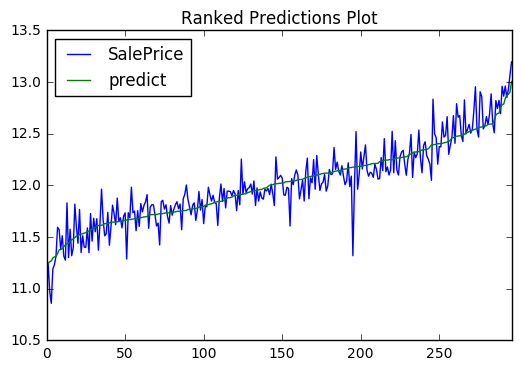

In [24]:
glm3 = glm_grid(encoded_combined_nums + ['predict', 'predict0', 'predict1'], 'SalePrice', stack_train, stack_valid)

#### Score test data

In [25]:
sub = test['Id'].cbind(glm3.predict(test))
sub['predict'] = sub['predict'].exp()
print(sub.head())

glm prediction progress: |████████████████████████████████████████████████| 100%


Id,predict
1461,110438
1462,146405
1463,162802
1464,191178
1465,187564
1466,164869
1467,178578
1468,157863
1469,185969
1470,118492


#### Create submission

In [26]:
# create time stamp
import re
import time
time_stamp = re.sub('[: ]', '_', time.asctime())

# save file for submission
sub.columns = ['Id', 'SalePrice']
sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
h2o.download_csv(sub, sub_fname)

In [27]:
# Shutdown H2O - this will erase all your unsaved frames and models in H2O
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_a950 closed.
